## COMP9418 - Assignment 1 - Bayesian Networks as Classifiers

## UNSW Sydney, October 2020

- Jeremie Kull - z5208518
- Pablo Pacheco - Z5222810

## Instructions

**Submission deadline:** Sunday, 18th October 2020, at 18:00:00.

**Late Submission Policy:** The penalty is set at 20% per late day. This is ceiling penalty, so if a group is marked 60/100 and they submitted two days late, they still get 60/100.

**Form of Submission:** This is a group assignment. Each group can have up to **two** students. **Only one member of the group should submit the assignment**.

You can reuse any piece of source code developed in the tutorials.

Submit your files using give. On a CSE Linux machine, type the following on the command-line:

``$ give cs9418 ass1 solution.zip``

Alternative, you can submit your solution via the [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/20T3).

## Technical prerequisites

These are the libraries your are allowed to use. No other libraries will be accepted.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from collections import OrderedDict as odict
from graphviz import Digraph
from tabulate import tabulate

## Initial task - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [2]:
G = {
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["Metastasis","MC","SkinRetract","NippleDischarge","AD","Mass"],
    "Mass" : ["Margin","Shape","Size"],
    "AD" : ["FibrTissueDev"],
    "Metastasis" : ["LymphNodes"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ["SkinRetract","NippleDischarge","Spiculation"],
    "LymphNodes" : [],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin"],
    "Margin" : [],
}

## [20 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: true if **X** is d-separated from **Y** given **Z** in the graph $G$ and false otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers, and can be assumed to be nodes of the graph $G$. 
* $G$ is a graph as defined in tutorial 1.

In [3]:
## Develop your code for d_separation(G, X, Z, Y) in one or more cells here

#We need to create a recursive function to delete the leaf nodes
def delete_leaf_node(G,X,Z,Y):
    G_aux=G.copy()
    for j in G_aux.keys():
        G_aux[j]=G[j].copy()
    for k in G_aux.keys():
        #check if we are in a leaf node
        if not G_aux[k]:
            #check if the leaf node is in X,Z or Y
            if (k not in X) and (k not in Z) and (k not in Y):
                #remove the leaf node
                G_aux.pop(k)
                #remove the node from the lists of the other nodes
                for i in G_aux.keys():
                    if k in G_aux[i]:
                        G_aux[i].remove(k)
                #Repeat the process with the new graph
                return delete_leaf_node(G_aux,X,Z,Y)
    #There is no more deletable node
    return G_aux
            
#Check connection between nodes using DFS

#This function does a DFS and paint grey every visited node, starting from x
def dfs_r(G, x, colour):
    # Visited vertices are coloured 'grey'
    colour[x] = 'grey'
    # Let's visit all outgoing edges from x
    for w in G[x]:
        # To avoid loops, we check if the next vertex hasn't been visited yet
        if colour[w] == 'white':
            dfs_r(G, w, colour)

#The next function returns True when there is a connection between X and Y
def check_connection(G,X,Y): 
    for i in X:
        # Create a dictionary with keys as node numbers and values equal to 'white'
        colour = {node: 'white' for node in G.keys()}
        dfs_r(G,i,colour)
        for j in Y:
            if colour[j]=='grey':
                return True     
    return False
    
def d_separation(G,X,Z,Y):
    #we get the new graph with some deleted nodes
    G_prime= delete_leaf_node(G,X,Z,Y)
  
    #Now, we need to delete the edges outgoing from nodes in Z
    for k in G_prime.keys():
        if k in Z:
            G_prime[k]=[]
    
    #Now, we need to check if X and Y are connected
    #Given the directions of the edges don't matter, we need to make an undirected graph
    G_undirected=G_prime.copy()
    for k in G_undirected.keys():
        G_undirected[k]=G_prime[k].copy()
    
    for k in G_prime.keys():
        for j in G_prime[k]:
            G_undirected[j].append(k)
    
    if check_connection(G_undirected,X,Y):
        #There is a connection, so X and Y are not d-separated
        return False
    else:
        #There is no a connection, so X and Y are d-separated
        return True  

In [4]:
############
## TEST CODE

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation','LymphNodes']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [10 Marks] Task 2 - Estimate Bayesian Network parameters from data

Implement a function ``learn_outcome_space(data)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``data`` and returns a dictionary ``outcomeSpace`` with these values.

Implement a function ``learn_bayes_net(G, data, outcomeSpace)`` that learns the parameters of the Bayesian Network $G$. This function should return a dictionary ``prob_tables`` with the all conditional probability tables (one for each node).

- ``G`` is a directed acyclic graph. For this part of the assignment, $G$ should be declared according to the breast cancer Bayesian network presented in the diagram in the assignment specification.
- ``data`` is a dataframe created from a csv file containing the relevant data. 
- ``outcomeSpace`` is defined in tutorials.
- ``prob_tables`` is a dict from each variable name (node) to a "factor". Factors are defined in tutorial 2. 

In [5]:
## Develop your code for learn_outcome_space(data) in one or more cells here

def learn_outcome_space(data):
    outcomeSpace=dict()
    for i in data.columns:
        outcomeSpace[i]=tuple(data[i].unique())
    return outcomeSpace


In [6]:
############
## TEST CODE

with open('bc.csv') as file:
    data = pd.read_csv(file)

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


In [6]:
## Develop your code for learn_bayes_net(G, data, outcomeSpace) in one or more cells here
#The first three function are the same as what we saw in the tutorial 3. 

#This function is used to get the parents of very node in order to get the conditional probabilities.
def transposeGraph(G):
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            GT[w].append(v)
    return GT

#This function is used to know where the given variables or parents or fixed_variables are happening.
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

#The next function gives the method to calculate the probability tables. It is going to be used by
# learn_bayes_net function
def estProbTable(data, var_name, parent_names, outcomeSpace): 
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    
    # Smoothing
    alpha = 1
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = ((var_index & parent_index).sum() + alpha) / (parent_index.sum() + alpha * len(var_outcomes))
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}

#The next function return the probability tables of each node, considering the given graph structure
def learn_bayes_net(G, data, outcomeSpace):
    prob_tables = odict()
    GT=transposeGraph(G)
    for node, parents in GT.items():
        prob_tables[node] = estProbTable(data,node,parents,outcomeSpace)
    return prob_tables

In [8]:
############
## TEST CODE

prob_tables = learn_bayes_net(G, data, outcomeSpace)
test(abs(prob_tables['Age']['table'][('35-49',)] - 0.2476) < 0.001)


Passed test case


## [20 Marks] Task 3 - Bayesian Network Classification

Design a new function ``assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)`` that uses the test cases in ``data`` to assess the performance of the Bayesian network defined by ``G`` and ``prob_tables``. Implement the efficient classification procedure discussed in the lectures. Such a function should return the classifier accuracy. 
 * ``class_var`` is the name of the variable you are predicting, using all other variables.
 * ``outcomeSpace`` was created in task 2
 
Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Return just the accuracy:

``acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)``

In [9]:
## Develop your code for assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

#Remove metastasis and lymphnodes from graph and dataset:
G = {
    "BreastDensity" : ["Mass"],
    "Location" : ["BC"],
    "Age" : ["BC"],
    "BC" : ["MC","SkinRetract","NippleDischarge","AD","Mass"],
    "Mass" : ["Margin","Shape","Size"],
    "AD" : ["FibrTissueDev"],
    "MC" : [],
    "Size" : [],
    "Shape" : [],
    "FibrTissueDev" : ["SkinRetract","NippleDischarge","Spiculation"],
    "SkinRetract" : [],
    "NippleDischarge" : [],
    "Spiculation" : ["Margin"],
    "Margin" : [],
}

data.drop(columns=['Metastasis','LymphNodes'],inplace=True)

In [10]:
#Markov Blanket of a variable class_var in a graph G. This returns a list with the nodes in the blanket
def blanket(G,class_var):
    blanket_list=list()
    #Children
    for i in G[class_var]:
        blanket_list.append(i)
    
    for k in G.keys():
        if k != class_var:
            #Spouses
            for child in G[k]:
                if child in G[class_var] and k not in blanket_list:
                    blanket_list.append(k)
                    break
            #Parents
            if class_var in G[k] and k not in blanket_list:
                blanket_list.append(k)
    return blanket_list

#function from tutorial to calculate probability given an entry
def prob(factor, *entry):
    return factor['table'][entry]  

#function from tutoral to calculate join probability given two factors
def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. 
    table = list()
    
    # The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        p1 = prob(f1, *f1_entry)           
        p2 = prob(f2, *f2_entry)        
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}

#Function from tutorial to get a new outcomespace given some evidence
def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      
    newOutcomeSpace[var] = (e,)             
    return newOutcomeSpace

#Function from tutorial to marginalize a variable from a factor
def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
                      
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 
            s = s + p                            # Sum over all values of var by accumulating the sum in s.
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}


#Function from tutorial to make queries, the only difference is that this function does not normalize at 
#the end. Given that we are classifying, it is just needed to choose the most likely one. In addition, we are
#assuming that q_vars is going to be just one variable because we are doing classification.
def query(p, outcomeSpace, q_vars, **q_evi):
    """
    argument 
    `p`, probability table to query.
    `outcomeSpace`, dictionary will variable domains
    `q_vars`, list of variables in query head
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns a new factor  with all hidden variables eliminated as evidence set as in q_evi
    """     
    
    # Let's make a copy of these structures, since we will reuse the variable names
    pm = p.copy()
    outSpace = outcomeSpace.copy()
    
    # First, we set the evidence 
    for var_evi, e in q_evi.items():
        outSpace = evidence(var_evi, e, outSpace)
        
    # Second, we eliminate hidden variables NOT in the query
    for var in outSpace:
        if var != q_vars:                         #this is different to the tutorial, we are assuming just one var
            pm = marginalize(pm, var, outSpace)
    return pm


def assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var):
    
    # We are going to use just the Markovian Blanket as evidence, instead of using all variables
    blanket_list= blanket(G,class_var)
    
    # blanket_indexes
    blanket_dict=dict()
    for b in blanket_list:
        blanket_dict[b]=data.columns.get_loc(b)
    # class_var index
    class_var_index=data.columns.get_loc(class_var)
    
    def n_cons(e):
        cons = len(G[e])
        for i in G.keys():
            if e in G[i]: cons += 1
        return cons
    
    # print(blanket_list)
    
    # Using MinDegreeOrder talked about in lectures significantly improves performance for TAN probability table joining
    blanket_list.sort(reverse=True, key=n_cons)

    # we need to compute the full joint probability of the Bayesian network (using joint function)
    p_join=prob_tables[class_var]
    for k in blanket_list:
        p_join = join(p_join, prob_tables[k], outcomeSpace)
        
    # we need a new outcomeSpace with only the variables in the blanket and its parents
    # Given that we have complete data, we just need the joint probability of the 
    # markovian balnket of the class_var because of the independencies
    outcomeSpace_join=dict()
    for k in p_join['dom']:
        outcomeSpace_join[k]=outcomeSpace[k]
    
    n_coincidence=0
    n_rows=len(data.index)
    
    
    # working with numpy for more efficiency
    #data2=data.to_numpy()    #This could be the best option, but CSE servers don't have the requiered version of pandas
    data2=data.values
    # Now, we can make queries. We are going to use query function, which uses marginalization
    for row in data2:
        # create dictionary with the given variables in blanket
        evidence=dict()
        for b in blanket_list:
            evidence[b]=row[blanket_dict[b]]
        # make the query
        proba=query(p_join,outcomeSpace_join,class_var,**evidence)
        # check the most likely
        max_prob = -1
        classification=''
        for i in proba['table'].keys():
            if proba['table'][i] > max_prob:
                max_prob=proba['table'][i]
                classification=i[0]
        # Check if it was correct classified
        if classification==row[class_var_index]:
            n_coincidence +=1

    return n_coincidence/n_rows
             

In [11]:
#outcomeSpace and prob_tables considering the 2 removed variables
outcomeSpace = learn_outcome_space(data)
prob_tables = learn_bayes_net(G, data, outcomeSpace)
#Defining variable to classify
class_var='BC'

In [12]:
############
## TEST CODE
import time
start = time.time()

acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)

end = time.time()
print(end - start)
print(acc)

2.612837791442871
0.8423


Develop a function ``cv_bayes_net(G, data, class_var)`` that uses ``learn_outcome_space``, ``learn_bayes_net``and ``assess_bayes_net`` to learn and assess a Bayesian network in a dataset using 10-fold cross-validation. Compute and report the average accuracy over the ten cross-validation runs as well as the standard deviation, e.g.

``acc, stddev = cv_bayes_net(G, data, class_var)``

In [13]:
## Develop your code for cv_bayes_net(G, data, class_var) in one or more cells here

def cv_bayes_net(G, data, class_var):
    #Getting the outcomeSpace. It is obtained from the all data, because I know what are the all possibilities
    #that I'm going to classify. What could happened is that we don't see any of those combinations in the training data
    outcomeSpace = learn_outcome_space(data)
    
    #we need to split the data in k=10
    n_folds=10
    acc_array=np.ones(n_folds)
    #data2=data.to_numpy()
    data2=data.values
    k_folds= np.array_split(data2,n_folds)
    
    for k in range(n_folds):
        test_data=pd.DataFrame(k_folds[k],columns=data.keys())
        
        if k==0:
            training=k_folds[k+1]
            for j in range(k+2,n_folds):
                training= np.concatenate((training,k_folds[j]),axis=0)
        else:
            training=k_folds[0]
            for j in range(1,n_folds):
                if j!=k:
                    training=np.concatenate((training,k_folds[j]),axis=0)
        
        training_data = pd.DataFrame(training,columns=data.keys())
        
        
        #learn the bayesian network from training data
        prob_tables=learn_bayes_net(G, training_data, outcomeSpace)
        
        #We have a model, now we need to evaluate it (using test data)
        acc_array[k]= assess_bayes_net(G, prob_tables, test_data, outcomeSpace, class_var)
      
            
    #we are going to use population standard deviation of numpy     
    #print('array:',acc_array)    
    return (np.average(acc_array),np.std(acc_array))



In [14]:
############
## TEST CODE
start=time.time()
acc, stddev = cv_bayes_net(G, data, 'BC')
end=time.time()
print('time:',end-start)
print(acc,stddev)

time: 7.345041275024414
0.8412000000000001 0.00580603134679791


## [10 Marks] Task 4 - Naïve Bayes Classification

Design a new function ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to classify and assess the test cases in a dataset ``data`` according to the Naïve Bayes classifier. To classify each example, use the log probability trick discussed in the lectures. This function should return the accuracy of the classifier in ``data``.

In [15]:
## Develop your code for assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var) in one or more cells here

def assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var):    
    #We are ASSUMMING that G HAS THE NAIVE BAYES STRUCTURE
    #And we are assumming complete data, so every node in the graph is going to have a column in data
   

    #evidence_indexes
    evi_index=dict()
    for i in G.keys():
        if i!=class_var:
            evi_index[i]=data.columns.get_loc(i)
    #class_var index
    class_var_index=data.columns.get_loc(class_var)
  
    n_coincidence=0
    n_rows=len(data.index)
    
    #data2=data.to_numpy()
    data2=data.values
    
    for row in data2:
        #create dictionary with the given variables
        evidence=dict()
        for i in evi_index.keys():
            evidence[i]=row[evi_index[i]]
                   
        max_prob=-1000000000000000
        classification=''
        #Given naive bayes assumption, we can use directly the conditional probability tables
        #calculate probability for each value of class_var using naive bayes assumption
        for v in outcomeSpace[class_var]:
            #the first component of the joint probability is P(class_var). We are going to use the log 'trick'
            if prob_tables[class_var]['table'][(v,)] > 0:
                prob_v= math.log(prob_tables[class_var]['table'][(v,)])
            else:
                prob_v=-1000000
            #Now, we compute the rest of the probability. So, we need to sum (we are using log) the probability
            #of every evidence given class_var
            for e in evidence:
                if prob_tables[e]['table'][(v,evidence[e])] > 0:
                    prob_v = prob_v + math.log(prob_tables[e]['table'][(v,evidence[e])])
                else:
                    prob_v = prob_v -1000000
            if prob_v > max_prob:
                classification=v
                max_prob=prob_v
            
        #Check if it was correct classified
        if classification==row[class_var_index]:
            n_coincidence +=1
    
    return n_coincidence/n_rows


In [16]:
############
## TEST CODE
#THIS JUST WORK WHEN YOU GIVE A GRAPH G WITH A NAIVE STRUCTURE
#prob_tables=learn_bayes_net(naive_graph, data, outcomeSpace)
#acc = assess_naive_bayes(naive_graph, prob_tables, data, outcomeSpace, 'BC')
#print(acc)

Develop a new function ``cv_naive_bayes(data, class_var)`` that uses ``assess_naive_bayes`` to assess the performance of the Naïve Bayes classifier in a dataset ``data``. To develop this code, perform the following steps:

1. Use 10-fold cross-validation to split the data into training and test sets.

2. Implement a function ``learn_naive_bayes_structure(outcomeSpace, class_var)`` to create and return a Naïve Bayes graph structure from ``outcomeSpace`` and ``class_var``. 

3. Use ``learn_bayes_net(G, data, outcomeSpace)`` to learn the Naïve Bayes parameters from a training set ``data``. 

4. Use ``assess_naive_bayes(G, prob_tables, data, outcomeSpace, class_var)`` to compute the accuracy of the Naïve Bayes classifier in a test set ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy.

Do 10-fold cross-validation, same as above, and return ``acc`` and ``stddev``.

In [16]:
## Develop your code for learn_naive_bayes_structure(outcomeSpace, class_var) in one or more cells here
#This function makes the class_var the oly parent of all other variables (nodes)
def learn_naive_bayes_structure(outcomeSpace,class_var): 
    new_G=dict()
    for k in outcomeSpace.keys():
        if k==class_var:
            new_G[k]=list(outcomeSpace.keys())
            new_G[k].remove(k)
        else:
            new_G[k]=[]
    return new_G

In [17]:
############
## TEST CODE

naive_graph = learn_naive_bayes_structure(outcomeSpace, 'BC')
prueba=learn_bayes_net(naive_graph,data,outcomeSpace)

In [18]:
## Develop your code for cv_naive_bayes(data, class_var) in one or more cells here

def cv_naive_bayes(data, class_var):
    # get the outcomeSpace. It is obtained from the all data, because we know what are the all possibilities
    # that we going to classify. What could happened is that we don't see any of those combinations in the training data
    outcomeSpace = learn_outcome_space(data)
    
    G = learn_naive_bayes_structure(outcomeSpace, class_var)
    
    # we need to split the data in k=10
    n_folds=10
    acc_array=np.ones(n_folds)
    #data2=data.to_numpy()
    data2=data.values
    k_folds= np.array_split(data2,n_folds)
    
    for k in range(n_folds):
        test_data=pd.DataFrame(k_folds[k],columns=data.keys())
        
        if k==0:
            training=k_folds[k+1]
            for j in range(k+2,n_folds):
                training= np.concatenate((training,k_folds[j]),axis=0)
        else:
            training=k_folds[0]
            for j in range(1,n_folds):
                if j!=k:
                    training=np.concatenate((training,k_folds[j]),axis=0)
        
        training_data = pd.DataFrame(training,columns=data.keys())
        
        
        # learn the bayesian network from training data
        prob_tables=learn_bayes_net(G, training_data, outcomeSpace)
        
        # We have a model, now we need to evaluate it (using test data)
        acc_array[k]= assess_naive_bayes(G, prob_tables, test_data, outcomeSpace, class_var)
        
        # Unoptimised general version:
        #acc_array[k]= assess_bayes_net(G, prob_tables, test_data, outcomeSpace, class_var)
      
            
    # we are going to use population standard deviation of numpy     
    # print('array:',acc_array)    
    return (np.average(acc_array),np.std(acc_array))


In [19]:
############
## TEST CODE
start=time.time()
acc, stddev = cv_naive_bayes(data, 'BC')
end=time.time()
print(end-start)
print(acc,stddev)

2.0318539142608643
0.79185 0.008697844560579362


## [20 Marks] Task 5 - Tree-augmented Naïve Bayes Classification

Similarly to the previous task, implement a Tree-augmented Naïve Bayes (TAN) classifier and evaluate your implementation in the breast cancer dataset. Design a function ``learn_tan_structure(data, outcomeSpace, class_var)`` to learn the TAN structure (graph) from the ``data`` and returns such a structure.

In [20]:
def prim(G, m, vals):
    """
    argument 
    `G`, an adjacency list representation of a graph
    `s`, start vertex
    """      
    s = vals[0]
    # Intialise set S with vertex s
    S = {s}
    # Initialise priority queue Q with an empty list
    Q = []
    # Initilise list tree with empty list. This variable will have the MST at the end of the execution
    tree = []
    # Initilise the priority queue Q with outgoing edges from s
    for e in G[s]:
        # There is a trick here. Python prioriy queues accept tuples but the first entry of the tuple must be the priority value
        pq.heappush(Q, [-m[vals.index(s)][vals.index(e)], s, e])
    while len(Q) > 0:
        # Remove element from Q with the smallest weight
        [cost, v, u] = pq.heappop(Q)
        # If the node is already in S we cannot include it in the MST since it would create a cycle
        if not u in S:
            # Let's grow the MST by inserting the vertex in S
            S.add(u)
            # Also we insert the edge in tree, use v, u, cost order
            tree.append([v, u, cost])
            # We iterate over all outgoing edges of u[1] (or "v" according to the algorithm)
            for e in G[u]:
                # We are interested in edges that connect to vertices not is S and with smaller weight than known values stores in a
                if not e in S:
                    # Edge e is of interest, let's store in the priority queue for future analysis
                    pq.heappush(Q, [-m[vals.index(u)][vals.index(e)], u, e])        
    return tree
        
#######################################
# Test code
#######################################

## Develop your code for learn_tan_structure(data, outcomeSpace, class_var) in one or more cells here
def learn_tan_structure(data, outcomeSpace, class_var):
    new_G = dict()
    vals = list(outcomeSpace.keys())
    c = vals.index(class_var)
    vals.remove(class_var)

    m = [[0 for i in range(len(vals))] for i in range(len(vals))]

    # print(outcomeSpace)
    # print(class_var)
    # print("#####################")
    # print(data)
    
    #data2 = data.to_numpy()
    data2=data.values

    for k in range(len(vals)):
        if (k == c): continue
        for j in range(k + 1, len(vals)):
            v1 = vals[k]
            v2 = vals[j]
            
            # Since we skip the c'th collumn we need to do this
            data_k = k
            data_j = j
            if (k > c):
                data_k += 1
            if (j > c):
                data_j += 1

            M = 0
            for o3 in outcomeSpace[class_var]:
                c_true = (data2[:,c] == o3)
                count_c = np.count_nonzero(c_true)
                for o1 in outcomeSpace[v1]:
                    v1_true = (data2[:,data_k] == o1)
                    for o2 in outcomeSpace[v2]:
                        v2_true = (data2[:,data_j] == o2)
                        # use columns
                        count_v1_v2_c = np.count_nonzero(v1_true & v2_true & c_true)
                        count_v1_c = np.count_nonzero(v1_true & c_true)
                        count_v2_c = np.count_nonzero(v2_true & c_true)
                        
                        # Using smoothing                        
                        alpha = 1
                        
                        # P(v1 = o1, v2 = o2 | c = o3)
                        P_v1_v2_lc = (count_v1_v2_c + alpha) / (count_c + alpha * len(outcomeSpace[v1]) * len(outcomeSpace[v2]))
                        # P(v1 = o1 | c = o3)
                        P_v1_lc = (count_v1_c + alpha) / (count_c + alpha * len(outcomeSpace[v1]))
                        # P(v2 = o1 | c = o3)
                        P_v2_lc = (count_v2_c + alpha) / (count_c + alpha * len(outcomeSpace[v2]))
                        # P(v1 = o1, v2 = o2, c = o3)
                        n_vals = len(outcomeSpace[class_var]) * len(outcomeSpace[v1]) * len(outcomeSpace[v2])
                        P_v1_v2_c = (count_v1_v2_c + alpha) / (data2.shape[0] + alpha * n_vals)
                        
                        
                        # Just in case (shouldn't need it due to smoothing)
                        if (not P_v1_v2_lc): P_v1_v2_lc = 0.000001
                        if (not P_v1_lc): P_v1_lc = 0.000001
                        if (not P_v2_lc): P_v2_lc = 0.000001
                        
                        # print(P_v1_v2_lc, (P_v1_lc * P_v2_lc), P_v1_v2_lc / (P_v1_lc * P_v2_lc))

                        M += P_v1_v2_c * math.log(P_v1_v2_lc / (P_v1_lc * P_v2_lc))
            
            m[k][j] = M
            m[j][k] = M

    # [[print(int(i*100), end=' ') for i in l] and print() for l in m]
    
    G = {}
    for i in vals: G[i] = [j for j in vals]
    # print(G)
    # print()
    max_span = prim(G, m, vals)
    
    # TODO # make directed tree
    
    n_m = {}
    n_m[class_var] = vals
    # n_m[tmp[0][0]] = [tmp[0][1]]
    # added = [tmp[0][0]]
    # del tmp[0]
    
    queue = [max_span[0][0]]
    # queue <- max_span[0]
    # pop(), then find all edges that connect to it, add the other end to the queue, remove edge from max_span
    # until all vertex are added
    
    # Both directions
    while len(queue):
        val = queue.pop(0)
        n_m[val] = []
        i = 0
        while i < len(max_span):
            if max_span[i][0] == val:
                n_m[val] += [max_span[i][1]]
                queue.append(max_span[i][1])
                max_span.remove(max_span[i])
            elif max_span[i][1] == val:
                n_m[val] += [max_span[i][0]]
                queue.append(max_span[i][0])
                max_span.remove(max_span[i])
            else:
                i += 1
#         if v[0] in n_m.keys(): n_m[v[0]] += [v[1]]
#         else:  n_m[v[0]] = [v[1]]
        
#         if v[1] in n_m.keys(): n_m[v[1]] += [v[0]]
#         else:  n_m[v[1]] = [v[0]]    
    
    # print(n_m)
    
    return n_m

In [21]:
############
## TEST CODE
start=time.time()

tan_graph = learn_tan_structure(data, outcomeSpace, class_var)
#print(tan_graph)
end=time.time()
print(end-start)

test(len(tan_graph['BC']) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph['Spiculation'] or 'Spiculation' in tan_graph['FibrTissueDev'])

1.1415932178497314
Passed test case
Passed test case


Similarly to the other tasks, design a function ``cv_tan(data, class_var)`` that uses 10-fold cross-validation to assess the performance of the TAN classifier from ``data``. Remember to remove the variables ``metastasis`` and ``lymphnodes`` from the dataset before assessing the accuracy. This function should use the ``learn_tan_structure`` as well as other functions defined in this notebook.

In [22]:
## Develop your code for cv_tan(data, class_var) in one or more cells here
def cv_tan(data, class_var):
    #get the outcomeSpace. It is obtained from the all data, because we know what are the all possibilities
    #that we going to classify. What could happened is that we don't see any of those combinations in the training data
    outcomeSpace = learn_outcome_space(data)
    
    # G = learn_naive_bayes_structure(outcomeSpace,class_var)
    # print(G)
    # print("--------------")
    
    # print(G)
    
    #we need to split the data in k=10
    n_folds=10
    acc_array=np.ones(n_folds)
    #data2=data.to_numpy()
    data2=data.values
    k_folds= np.array_split(data2,n_folds)
    
    for k in range(n_folds):
        test_data=pd.DataFrame(k_folds[k], columns=data.keys())
        
        if k==0:
            training=k_folds[k+1]
            for j in range(k+2,n_folds):
                training= np.concatenate((training, k_folds[j]),axis=0)
        else:
            training=k_folds[0]
            for j in range(1,n_folds):
                if j!=k:
                    training=np.concatenate((training, k_folds[j]),axis=0)
        
        training_data = pd.DataFrame(training,columns=data.keys())
        
        G = learn_tan_structure(training_data, outcomeSpace, class_var)
        
        #learn the bayesian network from training data
        prob_tables = learn_bayes_net(G, training_data, outcomeSpace)
        
        #We have a model, now we need to evaluate it (using test data)
        acc_array[k]= assess_bayes_net(G, prob_tables, test_data, outcomeSpace, class_var)
      
            
    #we are going to use population standard deviation of numpy     
    #print('array:', acc_array)    
    return (np.average(acc_array), np.std(acc_array))


# outcomeSpace = learn_outcome_space(data)
# G = learn_tan_structure(data, outcomeSpace, class_var)
# print("start")
# start=time.time()
# acc = assess_bayes_net(G, prob_tables, data, outcomeSpace, class_var)
# print(time.time()-start)
# print(acc)

In [23]:
############
## TEST CODE
start=time.time()
acc, stddev = cv_tan(data, 'BC')
end=time.time()
print(end-start)
print(acc,stddev)

100.32281923294067
0.8174499999999998 0.005815711478400541


## [20 Marks] Task 6 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results (accuracy). Use plots to illustrate your results.

b. Discuss the complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

In [24]:
## Develop your report in one or more cells here
import matplotlib.pyplot as plt

Our results are mostly consistent with what we expected, the first Bayes Network (GBN) runs the quickly (more details on speed later), and performs the best, at 0.8412 accuracy with 0.0058 standard deviation. The Naive Bayes (NB) runs slower (without using ‘assess_naive_bayes’), and has worse performance, at 0.7919 accuracy and 0.0087 SD, but can be optimised to run extremely fast using the NB assumption. Finally, the Tree Augmented Naive Bayes (TAN) runs a bit slower than NB, but performs better, however still worse than the BGN with 0.8174 accuracy and 0.0058 SD.

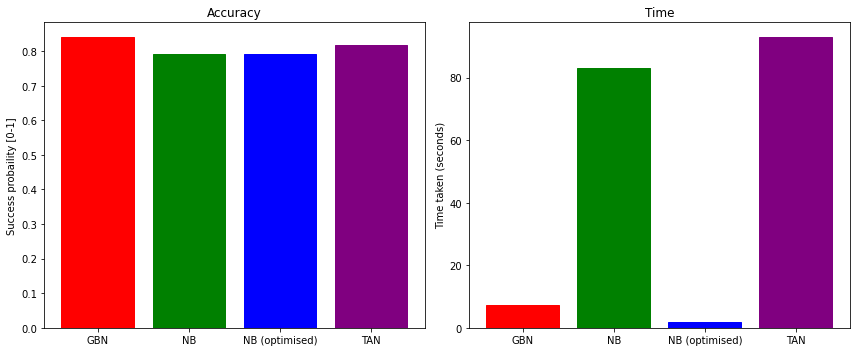

In [25]:
x = ['GBN', 'NB', 'NB (optimised)', 'TAN']
energy = [0.8412, 0.7919, 0.7919, 0.8174]

x_pos = [i for i, _ in enumerate(x)]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

barlist = ax1.bar(x_pos, energy)
barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('purple')
ax1.set_ylabel("Success probaility [0-1]")
ax1.set_title("Accuracy")

ax1.set_xticks(x_pos)
ax1.set_xticklabels(x)


x = ['GBN', 'NB', 'NB (optimised)', 'TAN']
energy = [7.172, 83.16, 1.828, 93.01]

x_pos = [i for i, _ in enumerate(x)]

barlist = ax2.bar(x_pos, energy)
barlist[0].set_color('red')
barlist[1].set_color('green')
barlist[2].set_color('blue')
barlist[3].set_color('purple')
ax2.set_ylabel("Time taken (seconds)")
ax2.set_title("Time")

ax2.set_xticks(x_pos)
ax2.set_xticklabels(x)

plt.tight_layout()
plt.show()

This makes sense, as our original GBN has the exact causal network given to it, whereas NB makes the generally incorrect assumption that all variables are independent. TAN figures out some dependency information from the data, so improves vs NB, but still relies on the data rather than the true causal links between variables, and thus performs worse than GBN. Referring to this (https://link.springer.com/chapter/10.1007%2F978-1-84882-171-2_1) paper on the topic of performance of GBN, NB and TAN’s, we see that this mostly supports our findings, as GBN should significantly outperform NB, and TAN should be better than NB. The only discrepancy is that the paper shows that GBN and TAN should be similar, whereas our data shows TAN performing worse. This is likely due to our GBN being constructed from ground truth biological causality, whereas they used heuristically generated GBN’s in the paper. 

The complexity of ‘assess_bayes_net’ is mostly dependent on the creation of the full joint probability network, which uses the ‘join’ function to combine multiple probability tables into a larger one. The complexity of this is roughly $O(|X|^n)$, where $|X|$ is the maximum outcome space size, and $n$ is the number of unique variables in the probability tables to be combined. Since this is exponential in the number of variables, using a Markov blanket to remove unnecessary variables greatly improves performance. Additionally, using MinDegreeOrder shown in lectures for variable elimination greatly helps speed up the calculation for the TAN. Despite these optimisations, this still takes a long time if the Markov blanket cannot reduce the number of variables involved, such as for the NB and TAN. We also made a super-fast version of ‘assess_naive_bayes’ that uses the fact that we don’t need to compute the full combined probability table for it, we can simply multiply the independent probabilities together.

Once the conditional probability table is made, querying the table for all data is $O(v n)$  where $v$ is the number of values in the dataset. This is very fast as it scales linearly with more data.

The creation of the TAN is $O(n^2 |X|^3 v^3)$, since the outcome spaces are fairly small, $|X|$ can be ignored, and the $v^3$ component is done using NumPy vectorised operations which are super fast compared to normal python loops and thus the TAN can be generated in about 1 second.

